# 금융 CSS 개발

이해원

전처리 내역 & 함수 목록
- get_loan_month: 대출기간 전처리
- get_work_year: 근로기간 전처리
- ID 컬럼 drop
- 부채_대비_소득_비율 9999 drop

컬럼 추가 내역
- get_plus_col
- get_home

## 2. 전처리 취합

In [22]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import sklearn 

plt.rcParams['font.family'] ='D2Coding'

In [23]:
train_df = pd.read_csv('C:/Users/LOVE/Downloads/vscode/CSS/train.csv')
test_df = pd.read_csv('C:/Users/LOVE/Downloads/vscode/CSS/test.csv')

train_df.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B


In [24]:
print(train_df.shape, test_df.shape)

(96294, 15) (64197, 14)


In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            96294 non-null  object 
 1   대출금액          96294 non-null  int64  
 2   대출기간          96294 non-null  object 
 3   근로기간          96294 non-null  object 
 4   주택소유상태        96294 non-null  object 
 5   연간소득          96294 non-null  int64  
 6   부채_대비_소득_비율   96294 non-null  float64
 7   총계좌수          96294 non-null  int64  
 8   대출목적          96294 non-null  object 
 9   최근_2년간_연체_횟수  96294 non-null  int64  
 10  총상환원금         96294 non-null  int64  
 11  총상환이자         96294 non-null  float64
 12  총연체금액         96294 non-null  float64
 13  연체계좌수         96294 non-null  float64
 14  대출등급          96294 non-null  object 
dtypes: float64(4), int64(5), object(6)
memory usage: 11.0+ MB


### (1) 전처리

In [26]:
# 대출기간 전처리
def get_loan_month(mt):
    return int(mt.strip().replace('months', ''))

train_df['대출기간'] = train_df['대출기간'].apply(get_loan_month)
train_df[['대출기간']]

,대출기간
0,36
1,60
2,36
3,36
4,60
...,...
96289,36
96290,60
96291,36
96292,36


In [27]:
# 근로기간 전처리
def get_work_year(yr):
    if yr in ['<1 year', '< 1 year']:
        return 0
    elif yr in ['1 year', '1 years']:
        return 1
    elif yr in ['10+ years', '10+years']:
        return 10
    # 'Unknown'은 NaN으로 대체
    elif yr == 'Unknown':
        return np.nan
    # 그 외는 숫자만 추출
    else:
        return int(''.join(filter(str.isdigit, yr)))

train_df['근로기간'] = train_df['근로기간'].apply(get_work_year)
train_df[['근로기간']]

,근로기간
0,6.0
1,10.0
2,5.0
3,8.0
4,NaN
...,...
96289,10.0
96290,10.0
96291,1.0
96292,5.0


In [28]:
# ID 컬럼 drop
train_df = train_df.drop('ID', axis = 1)

In [29]:
# 부채_대비_소득_비율 전처리
train_df = train_df.drop(train_df[train_df['부채_대비_소득_비율']==9999].index)

In [31]:
train_df.head()

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,12480000,36,6.0,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,14400000,60,10.0,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,12000000,36,5.0,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,14400000,36,8.0,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,18000000,60,NaN,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B


### (2) 추가할 컬럼

In [36]:
def get_plus_col(df):
    df['상환부담율'] = df['총상환이자'] / df['대출금액']
    df['상환율'] = df['총상환원금'] / df['대출금액']
    df['대출_대비_총상환금_비율'] = (df['총상환원금'] + df['총상환이자']) / df['대출금액']
    df['잔여상환금_대비_연체금액_비율'] = df['총연체금액'] / (df['대출금액'] - df['총상환원금'])
    df['연체계좌비율'] = df['연체계좌수'] / df['총계좌수']

get_plus_col(train_df)
train_df.head()

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,상환부담율,상환율,대출_대비_총상환금_비율,잔여상환금_대비_연체금액_비율,연체계좌비율
0,12480000,36,6.0,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C,0.000000,0.000000,0.000000,0.0,0.0
1,14400000,60,10.0,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B,0.016254,0.025943,0.042197,0.0,0.0
2,12000000,36,5.0,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A,0.012662,0.077387,0.090049,0.0,0.0
3,14400000,36,8.0,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C,0.010632,0.022627,0.033259,0.0,0.0
4,18000000,60,NaN,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B,0.008275,0.012697,0.020972,0.0,0.0


In [38]:
# 주택소유여부
def get_home(chr):
    if chr in ['MORTGAGE', 'RENT', 'ANY']:
        return 0
    else:
        return 1

train_df['주택소유여부'] = train_df['주택소유상태'].apply(get_home)
train_df.head()

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,상환부담율,상환율,대출_대비_총상환금_비율,잔여상환금_대비_연체금액_비율,연체계좌비율,주택소유여부
0,12480000,36,6.0,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C,0.000000,0.000000,0.000000,0.0,0.0,0
1,14400000,60,10.0,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B,0.016254,0.025943,0.042197,0.0,0.0,0
2,12000000,36,5.0,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A,0.012662,0.077387,0.090049,0.0,0.0,0
3,14400000,36,8.0,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C,0.010632,0.022627,0.033259,0.0,0.0,0
4,18000000,60,NaN,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B,0.008275,0.012697,0.020972,0.0,0.0,0


In [40]:
train_df.describe(include='all')

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,상환부담율,상환율,대출_대비_총상환금_비율,잔여상환금_대비_연체금액_비율,연체계좌비율,주택소유여부
count,9.629300e+04,96293.000000,90623.000000,96293,9.629300e+04,96293.000000,96293.000000,96293,96293.000000,9.629300e+04,9.629300e+04,96293.000000,96293.000000,96293,96293.000000,96293.000000,96293.000000,96288.000000,96293.000000,96293.000000
unique,NaN,NaN,NaN,4,NaN,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,MORTGAGE,NaN,NaN,NaN,부채 통합,NaN,NaN,NaN,NaN,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,47933,NaN,NaN,NaN,55150,NaN,NaN,NaN,NaN,NaN,28817,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.830414e+07,43.929548,6.007791,NaN,9.392770e+07,19.275952,25.304882,NaN,0.345664,8.225099e+05,4.282318e+05,54.381149,0.005805,NaN,0.022566,0.047841,0.070408,0.000005,0.000238,0.110641
std,1.032903e+07,11.288611,3.728511,NaN,9.956877e+07,9.624810,12.088616,NaN,0.919108,1.027749e+06,4.402120e+05,1414.776554,0.079967,NaN,0.015549,0.047854,0.054308,0.000268,0.003627,0.313689
min,1.200000e+06,36.000000,0.000000,NaN,1.440000e+06,0.000000,4.000000,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.020000e+07,36.000000,2.000000,NaN,5.760000e+07,12.650000,17.000000,NaN,0.000000,3.075720e+05,1.346160e+05,0.000000,0.000000,NaN,0.010841,0.023493,0.032797,0.000000,0.000000,0.000000
50%,1.680000e+07,36.000000,6.000000,NaN,7.800000e+07,18.740000,24.000000,NaN,0.000000,5.976960e+05,2.870160e+05,0.000000,0.000000,NaN,0.019492,0.043673,0.065304,0.000000,0.000000,0.000000
75%,2.400000e+07,60.000000,10.000000,NaN,1.128000e+08,25.540000,32.000000,NaN,0.000000,1.055076e+06,5.702280e+05,0.000000,0.000000,NaN,0.030988,0.069640,0.096486,0.000000,0.000000,0.000000


## 3. 상관관계

In [55]:
train_df2 = train_df.copy()

# A~G = 6~0
def get_grade_num(x):
    if x == 'A': return 6
    if x == 'B': return 5
    if x == 'C': return 4
    if x == 'D': return 3
    if x == 'E': return 2
    if x == 'F': return 1
    if x == 'G': return 0

train_df2['grade'] = train_df2['대출등급'].apply(lambda x : get_grade_num(x))
train_df2 = train_df2.drop(['대출등급'], axis = 1)
train_df2 = train_df2.drop(['주택소유상태'], axis = 1)
train_df2 = train_df2.drop(['대출목적'], axis = 1)
train_df2.head()

,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,상환부담율,상환율,대출_대비_총상환금_비율,잔여상환금_대비_연체금액_비율,연체계좌비율,주택소유여부,grade
0,12480000,36,6.0,72000000,18.90,15,0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0,4
1,14400000,60,10.0,130800000,22.33,21,0,373572,234060.0,0.0,0.0,0.016254,0.025943,0.042197,0.0,0.0,0,5
2,12000000,36,5.0,96000000,8.60,14,0,928644,151944.0,0.0,0.0,0.012662,0.077387,0.090049,0.0,0.0,0,6
3,14400000,36,8.0,132000000,15.09,15,0,325824,153108.0,0.0,0.0,0.010632,0.022627,0.033259,0.0,0.0,0,4
4,18000000,60,NaN,71736000,25.39,19,0,228540,148956.0,0.0,0.0,0.008275,0.012697,0.020972,0.0,0.0,0,5


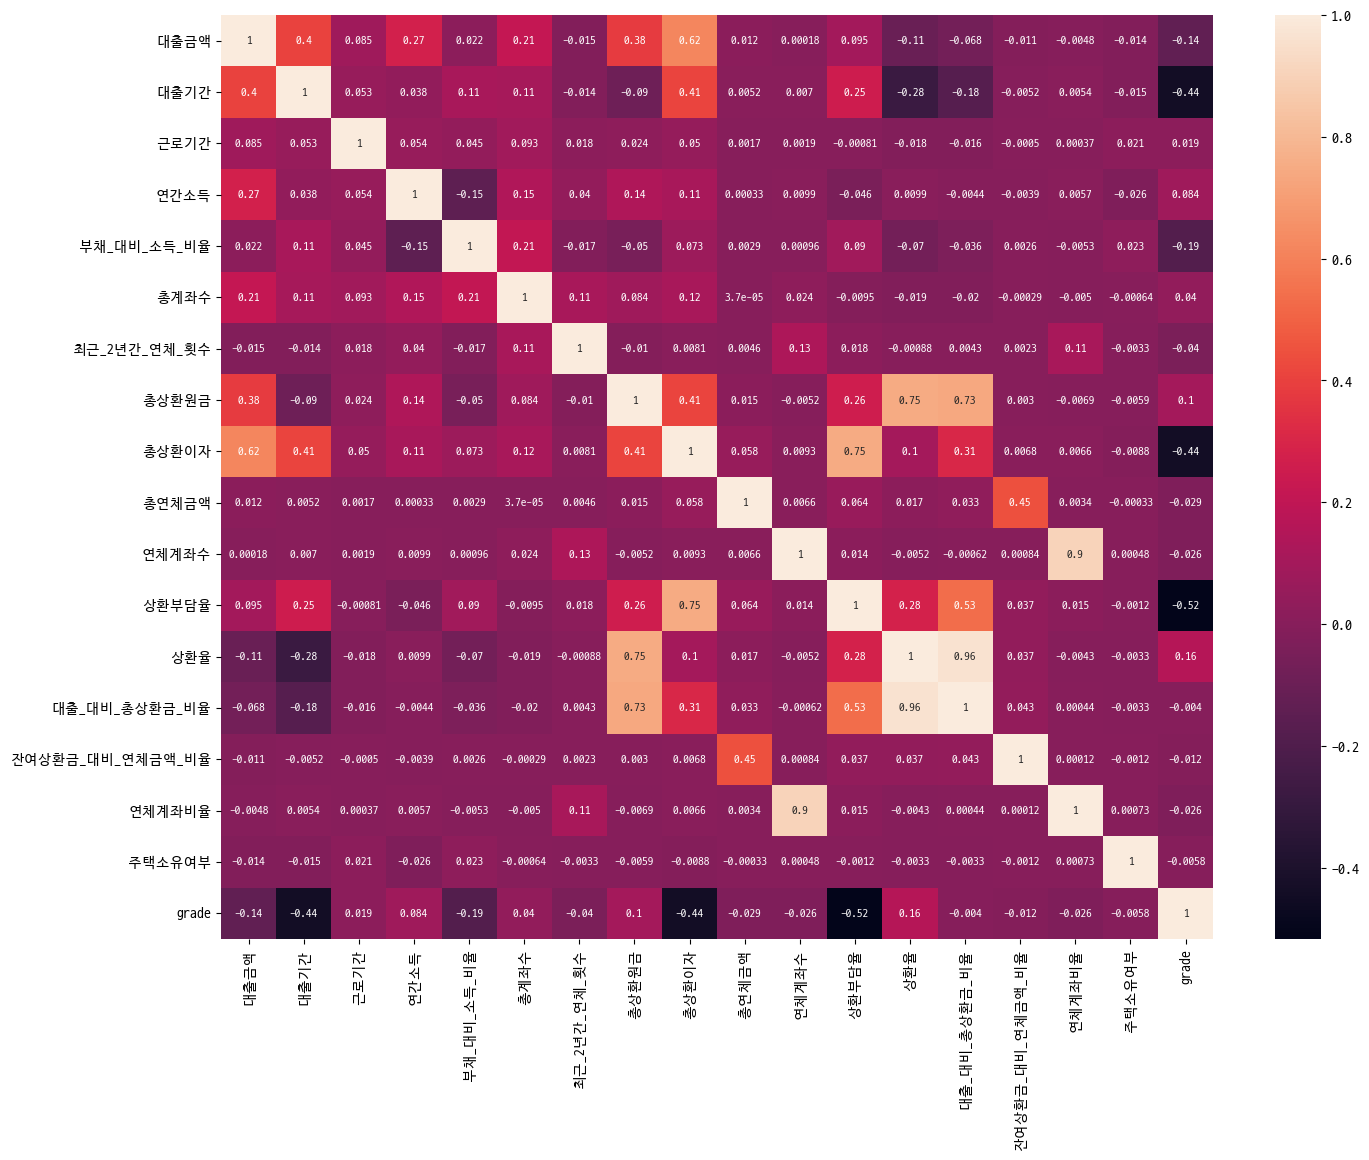

In [54]:
plt.rcParams["figure.figsize"] = (16,12)
sns.heatmap(train_df2.corr(), annot = True, annot_kws={"size": 8})
plt.show()

## 4. 모델

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

### (1) RF

In [73]:
model_rf = RandomForestClassifier()

X_features = ['총상환이자', '상환부담율', '상환율']

x = train_df2[X_features]
y = train_df2['grade']

model_rf.fit(x, y)
y_rf_pred = model_rf.predict(x)

def get_score(model_name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted') #각 클래스에 대한 F1 스코어를 계산하고, 클래스별 샘플 수에 따라 가중 평균을 계산하여 전체 F1 스코어를 얻음
    print(model_name, ')', 'acc 스코어: ', acc, ',', 'f1 스코어: ', f1)

get_score('rf', y, y_rf_pred)

rf ) acc 스코어:  0.9609628944990809 , f1 스코어:  0.961594497210905


In [75]:
model_rf2 = RandomForestClassifier()

X_features2 = ['상환부담율', '상환율', '대출_대비_총상환금_비율', '잔여상환금_대비_연체금액_비율', '연체계좌비율', '주택소유여부']

x2 = train_df2[X_features2]
y2 = train_df2['grade']

model_rf2.fit(x2, y2)
y_rf_pred2 = model_rf2.predict(x2)

get_score('rf2', y2, y_rf_pred2)

rf2 ) acc 스코어:  0.958782050616348 , f1 스코어:  0.9594020018022927


In [79]:
model_rf3 = RandomForestClassifier()

X_features3 = ['상환부담율', '총상환이자']

x3 = train_df2[X_features3]
y3 = train_df2['grade']

model_rf3.fit(x3, y3)
y_rf_pred3 = model_rf3.predict(x3)

get_score('rf3', y3, y_rf_pred3)

rf3 ) acc 스코어:  0.9595609234316098 , f1 스코어:  0.9602048750328438


### (2) XGB, LGBM

In [69]:
model_xgb = XGBClassifier(random_state=42)
model_lgb = LGBMClassifier(random_state=42)

model_xgb.fit(x, y)
model_lgb.fit(x, y)

y_xgb_pred = model_xgb.predict(x)
y_lgb_pred = model_lgb.predict(x)

get_score('xgb', y, y_xgb_pred)
get_score('lgb', y, y_lgb_pred)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 96293, number of used features: 3
[LightGBM] [Info] Start training from score -5.434896
[LightGBM] [Info] Start training from score -3.897517
[LightGBM] [Info] Start training from score -2.572151
[LightGBM] [Info] Start training from score -1.975580
[LightGBM] [Info] Start training from score -1.248783
[LightGBM] [Info] Start training from score -1.206430
[LightGBM] [Info] Start training from score -1.747685
xgb ) acc 스코어:  0.9505467687163137 , f1 스코어:  0.9511487619349858
lgb ) acc 스코어:  0.9499548253767148 , f1 스코어:  0.9505448711189083


In [76]:
model_xgb2 = XGBClassifier(random_state=42)
model_lgb2 = LGBMClassifier(random_state=42)

model_xgb2.fit(x2, y2)
model_lgb2.fit(x2, y2)

y_xgb_pred2 = model_xgb2.predict(x2)
y_lgb_pred2 = model_lgb2.predict(x2)

get_score('xgb2', y2, y_xgb_pred2)
get_score('lgb2', y2, y_lgb_pred2)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 884
[LightGBM] [Info] Number of data points in the train set: 96293, number of used features: 6
[LightGBM] [Info] Start training from score -5.434896
[LightGBM] [Info] Start training from score -3.897517
[LightGBM] [Info] Start training from score -2.572151
[LightGBM] [Info] Start training from score -1.975580
[LightGBM] [Info] Start training from score -1.248783
[LightGBM] [Info] Start training from score -1.206430
[LightGBM] [Info] Start training from score -1.747685
xgb2 ) acc 스코어:  0.9482101502705285 , f1 스코어:  0.9487646912211969
lgb2 ) acc 스코어:  0.948573624250984 , f1 스코어:  0.9491357618767534


In [80]:
model_xgb3 = XGBClassifier(random_state=42)
model_lgb3 = LGBMClassifier(random_state=42)

model_xgb3.fit(x3, y3)
model_lgb3.fit(x3, y3)

y_xgb_pred3 = model_xgb3.predict(x3)
y_lgb_pred3 = model_lgb3.predict(x3)

get_score('xgb3', y3, y_xgb_pred3)
get_score('lgb3', y3, y_lgb_pred3)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 96293, number of used features: 2
[LightGBM] [Info] Start training from score -5.434896
[LightGBM] [Info] Start training from score -3.897517
[LightGBM] [Info] Start training from score -2.572151
[LightGBM] [Info] Start training from score -1.975580
[LightGBM] [Info] Start training from score -1.248783
[LightGBM] [Info] Start training from score -1.206430
[LightGBM] [Info] Start training from score -1.747685
xgb3 ) acc 스코어:  0.7091792757521315 , f1 스코어:  0.7039715379551379
lgb3 ) acc 스코어:  0.7017436366090993 , f1 스코어:  0.6976398656510945


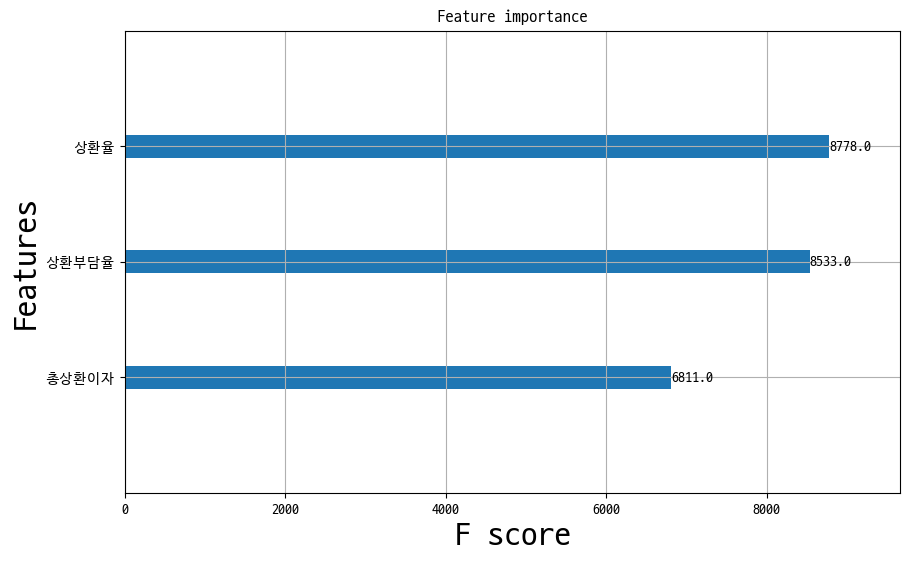

In [72]:
from xgboost import plot_importance
plt.rcParams["figure.figsize"] = (10,6)
plot_importance(model_xgb)
plt.show()

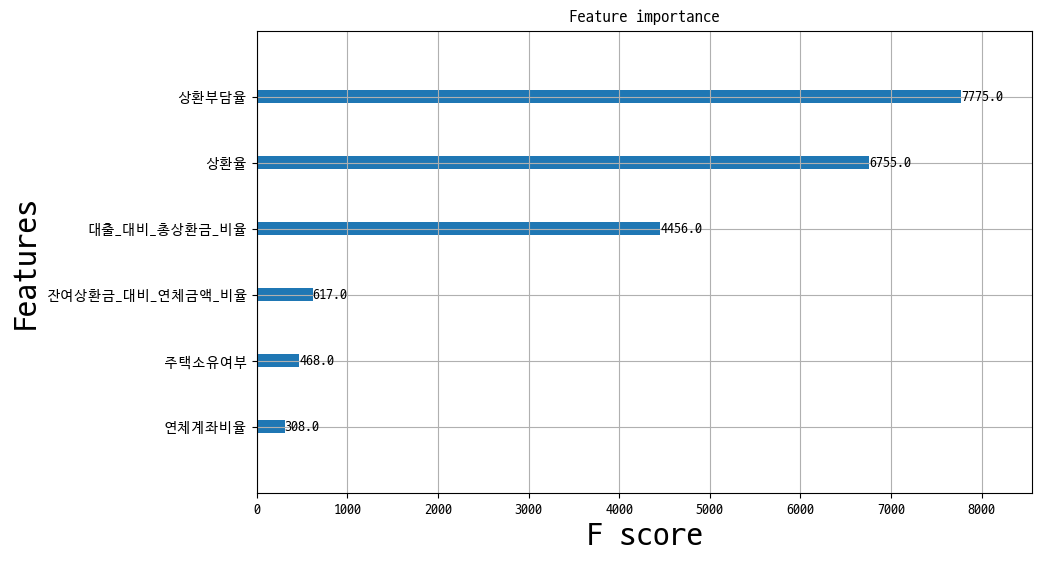

In [81]:
plt.rcParams["figure.figsize"] = (10,6)
plot_importance(model_xgb2)
plt.show()